In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
sys.path.append("../")
sys.path.append("../..")

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_Client_v2 as influx_Client, multipleDataSets
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)

In [58]:
start_time = "2021-09-12 00:00:00"
end_time = "2021-09-18 00:00:00"

from clust.integration.utils import param
dataInfo = [['air_indoor_modelSchool', 'ICW0W2000011'], 
            ['air_outdoor_kweather', 'OC3CL200012'],
            ['air_outdoor_keti_clean','seoul']]

refine_param = {
    "removeDuplication":{"flag":True},
    "staticFrequency":{"flag":True, "frequency":None}
}

CertainParam= {'flag': True}

uncertainParam= {'flag': False, "param":{
          "outlierDetectorConfig":[
                {'algorithm': 'IQR', 'percentile':99 ,'alg_parameter': {'weight':100}}    
]}}

outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":uncertainParam
}

imputation_param = {
    "flag":True,/0
    
    "imputation_method":[{"min":0,"max":3,"method":"linear", "parameter":{}}],
    "totalNonNanRatio":80
}

process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}

integration_freq_sec = 60 * 60 # 1시간
integration_param = {
    "integration_duration":"common",
    "integration_frequency":integration_freq_sec,
    "param":{},
    "method":"meta"
}

In [59]:
intDataInfo = param.makeIntDataInfoSet(dataInfo, start_time, end_time)
multiple_dataset  = multipleDataSets.get_onlyNumericDataSets(db_client, intDataInfo)

# 1. Data Integration & Scaling

In [60]:
from clust.integration.integrationInterface import IntegrationInterface
dataIntegrated = IntegrationInterface().multipleDatasetsIntegration(process_param, integration_param, multiple_dataset)

processingStart
processingEnd
integrationStart
integrationEnd


In [61]:
dataIntegrated.columns

Index(['CO2', 'Noise', 'PM10', 'PM25', 'Temp', 'VoCs', 'humid',
       'out_blacksphere_temp', 'out_co', 'out_coai', 'out_coci', 'out_h2s',
       'out_humi', 'out_light_intensity', 'out_nh3', 'out_no2', 'out_noise',
       'out_o3', 'out_pm10', 'out_pm25', 'out_so2', 'out_temp',
       'out_ultraviolet_rays', 'out_CO', 'out_NO2', 'out_O3', 'out_PM10',
       'out_PM25', 'out_SO2'],
      dtype='object')

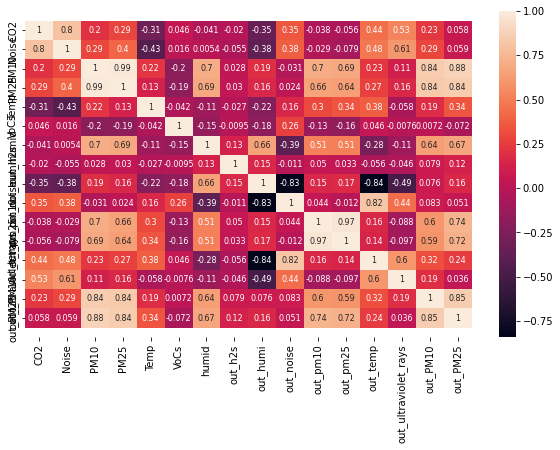

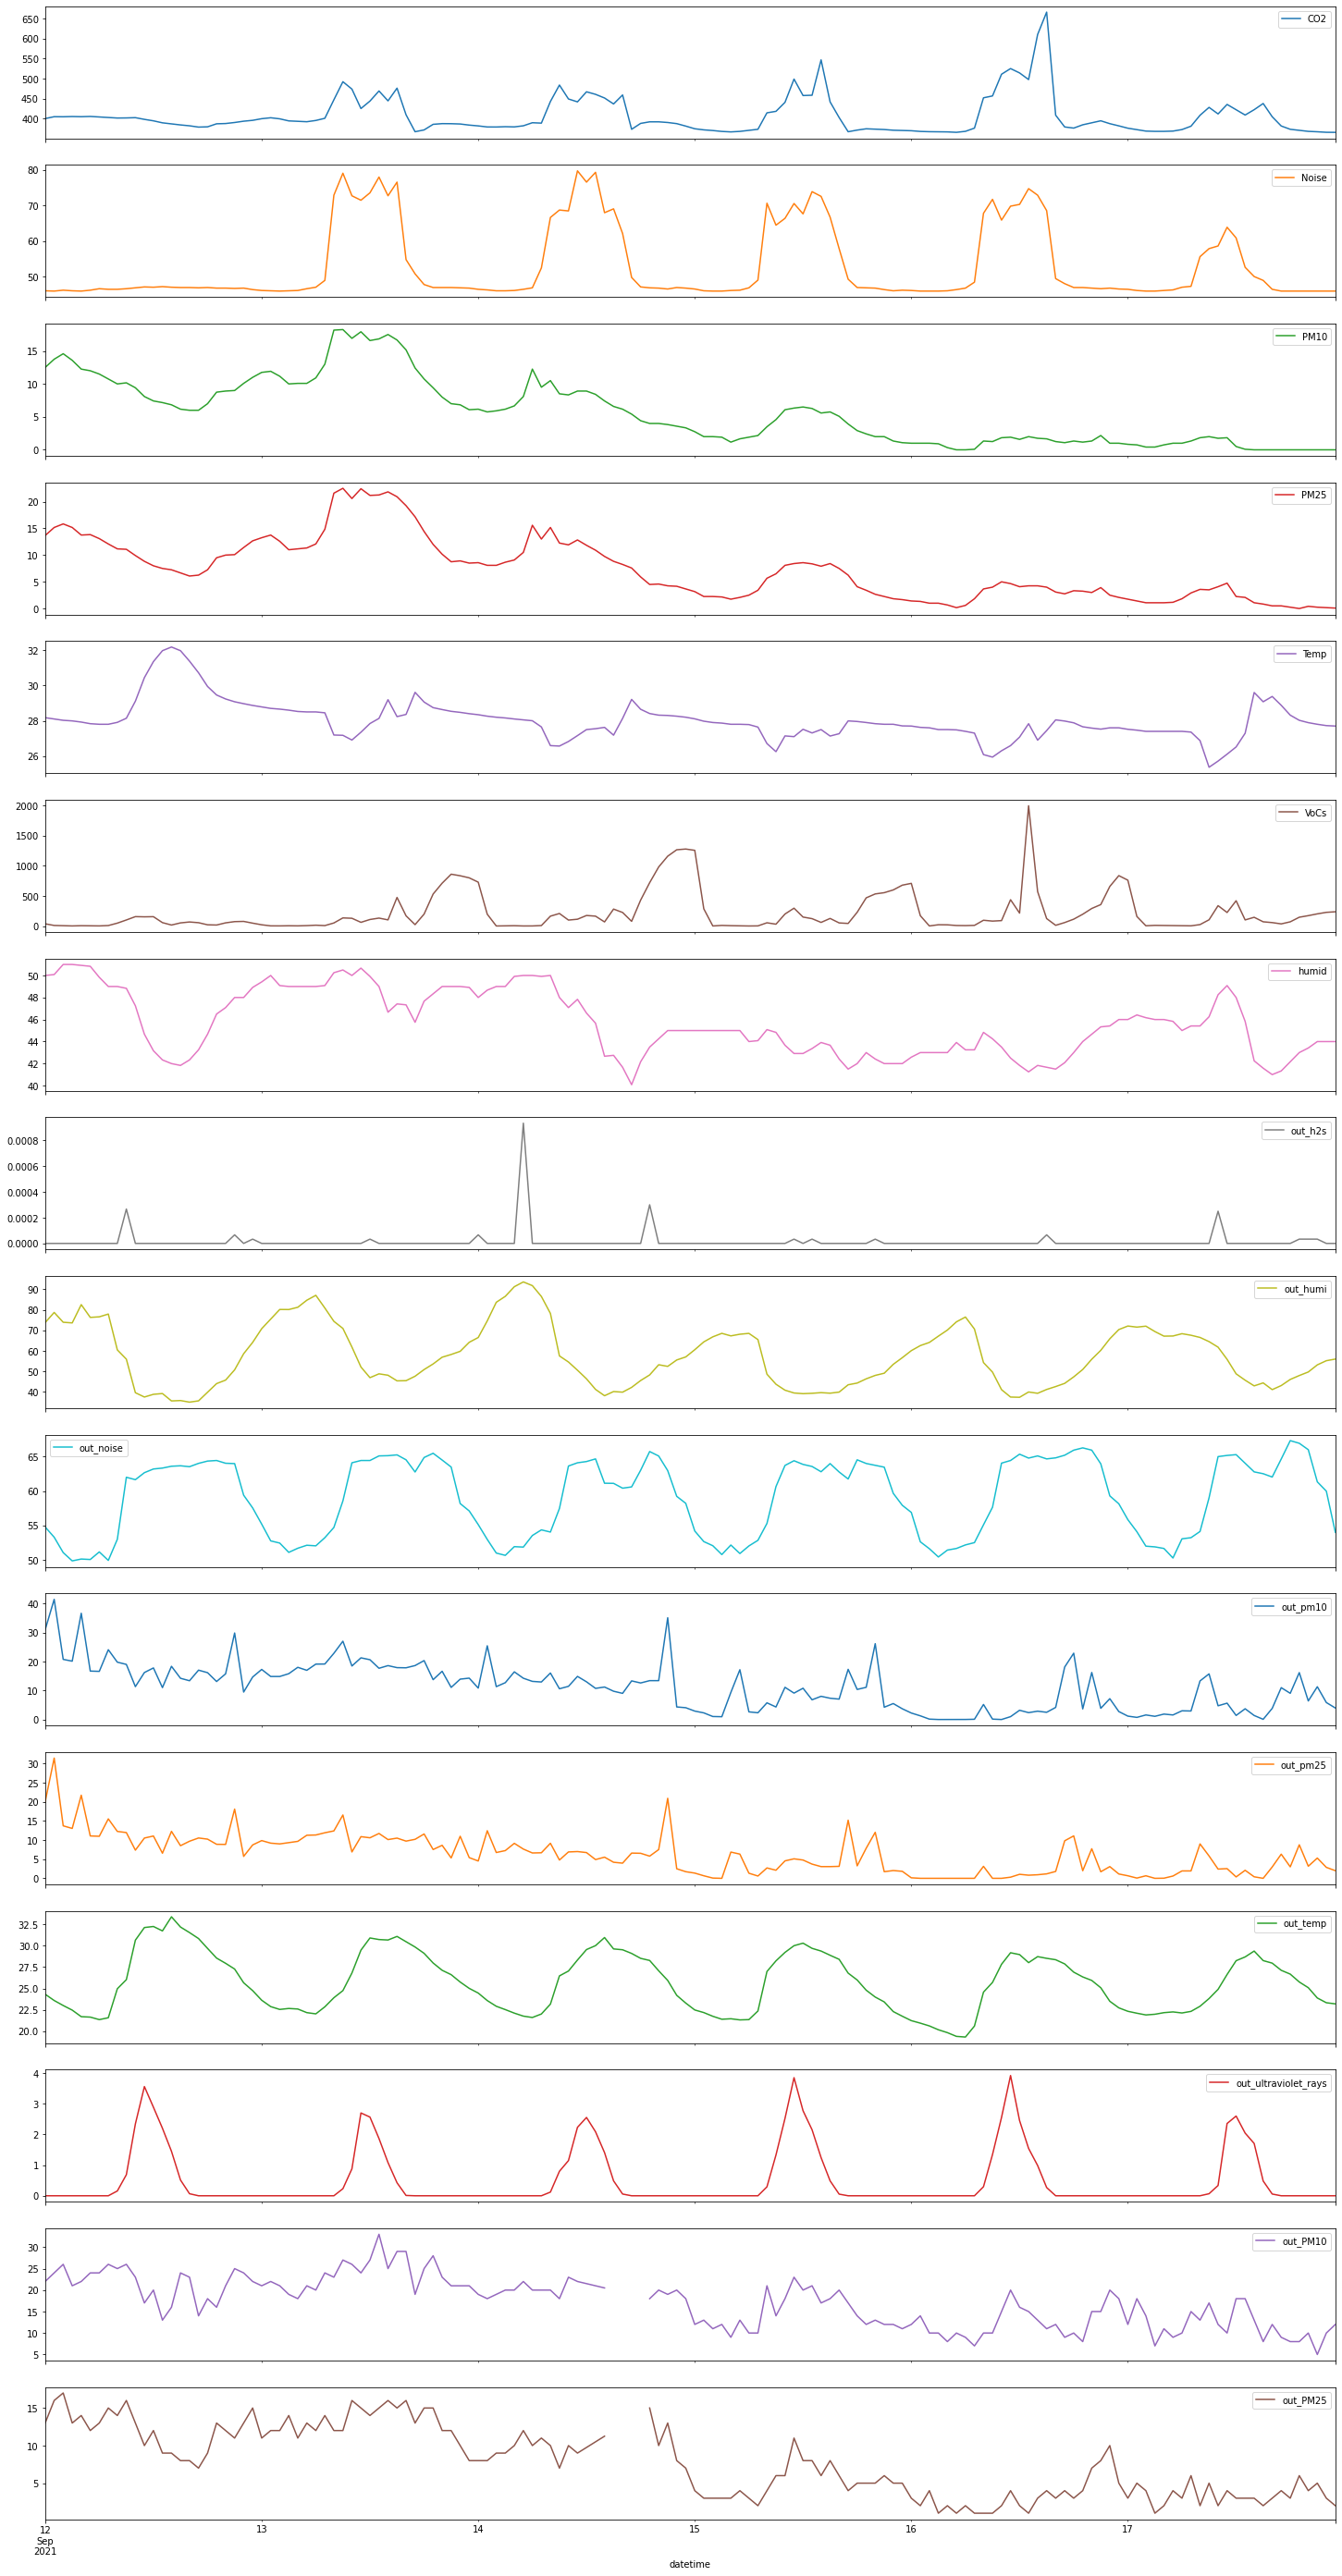

In [62]:
dataSet = dataIntegrated[['CO2', 'Noise', 'PM10', 'PM25', 'Temp', 'VoCs', 'humid',
        'out_h2s','out_humi', 'out_noise', 'out_pm10', 'out_pm25',  'out_temp',
       'out_ultraviolet_rays', 'out_PM10','out_PM25']]

from clust.tool.plot_graph import plot_features, plot_correlation
plt.rcParams['figure.figsize'] =(25, 50)
plot_correlation.plot_correlation_chart(dataSet)
plot_features.plot_all_feature_data(dataSet)

from clust.tool.stats_table.corr_table import Correlation
corrT = Correlation(dataSet)
topCorrelation = corrT.get_top_abs_correlations(50)

In [63]:
topCorrelation['PM10']

PM25        0.985481
out_PM25    0.884557
out_PM10    0.842785
humid       0.700004
out_pm10    0.698683
out_pm25    0.686764
dtype: float64

In [64]:
import math

def df_crosscorr(dataSet, column, lag_number):
    """
    
    """
    lags =np.arange(-lag_number, lag_number, 1)
    d1 = dataSet[column]
    d2DF = dataSet.drop(column, axis=1)

    result =pd.DataFrame(index = lags)
    for d2_column in d2DF.columns:
        d2 = d2DF[d2_column]
        result[d2_column] = timelag_crosscorr(d1, d2, lags)
    return result.round(2)
        
     
def timelag_crosscorr(datax, datay, lags):
    timeLagCrossCorr =[]
    result = np.nan_to_num([crosscorr(datax, datay, lag) for lag in lags])
    return result
        
    
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    """ 
    Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

def get_max_index_and_values(data):
    max_position_value = pd.DataFrame(columns = data.columns, index =['value', 'index'])
    for column in data.columns:
        index_num = data.idxmax()[column]
        max_position_value.loc["index", column] = index_num
        max_position_value.loc["value", column] = data.loc [index_num, column]

    return max_position_value

In [66]:
column = 'Noise'
lag_number = 24
result = df_crosscorr(dataSet, column, lag_number)
max_position_value = get_max_index_and_values(result)
max_position_value

,CO2,PM10,PM25,Temp,VoCs,humid,out_h2s,out_humi,out_noise,out_pm10,out_pm25,out_temp,out_ultraviolet_rays,out_PM10,out_PM25
value,0.8,0.33,0.4,0.48,0.64,0.25,0.2,0.71,0.63,0.22,0.2,0.83,0.7,0.36,0.21
index,0,23,0,19,-10,6,-20,8,19,18,18,22,23,23,23


NameError: name 'rs' is not defined

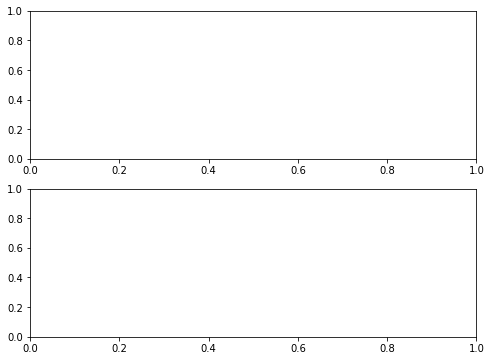

In [44]:

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=False)
maxrs, minrs = np.max(rs), np.min(rs)
if np.abs(maxrs) >= np.abs(minrs):
    corrval = maxrs
else:
    corrval = minrs

ax[1].plot(lags, rs, 'k', label='Xcorr (s1 vs s2), maxcorr: {:.2f}'.format(
    corrval), lw=0.5)

# ax[1].axvline(x=timeshift, c='r', lw=0.5, ls='--')
ax[1].axvline(x=lags[np.argmax(rs)], c='r', lw=0.5,
              ls='--', label='max time correlation')
ax[1].legend(fontsize=6)

plt.subplots_adjust(hspace=0.25, wspace=0.1)

plt.show()

In [ ]:

maxrs, minrs = np.max(rs), np.min(rs)
if np.abs(maxrs) >= np.abs(minrs):
    corrval = maxrs
else:
    corrval = minrs

ax[1].plot(lags, rs, 'k', label='Xcorr (s1 vs s2), maxcorr: {:.2f}'.format(
    corrval), lw=0.5)

# ax[1].axvline(x=timeshift, c='r', lw=0.5, ls='--')
ax[1].axvline(x=lags[np.argmax(rs)], c='r', lw=0.5,
              ls='--', label='max time correlation')
ax[1].legend(fontsize=6)

plt.subplots_adjust(hspace=0.25, wspace=0.1)

plt.show()

In [ ]:
for columnName in dataIntegrated.columns:
    dataIntegrated[[columnName]].plot()

## 2. Feature Extension & Selection

In [ ]:
from KETIAppTestCode.JWTest.LSTMTest import LSTMTest

"""
feature_col_list = ['CO2ppm', 'H2Sppm', 'Humidity', 'NH3ppm', 'Temperature', 'out_humid',
       'out_pressure', 'out_rainfall', 'out_sunshine', 'out_temp',
       'out_wind_direction', 'out_wind_speed', 'out_CO', 'out_NO2', 'out_O3',
       'out_PM10', 'out_PM25', 'out_SO2', 'day', 'sin_hour', 'cos_hour',
       'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month',
       'sin_week_of_year', 'cos_week_of_year']
"""
feature_col_list1 = ['CO2ppm', 'H2Sppm', 'Humidity', 'NH3ppm', 'Temperature', 'out_humid', 'out_temp', 'out_wind_speed',  'sin_hour']
target_name = 'Humidity'

In [ ]:
feature_col_list =  feature_col_list1
df_Exfeatures = LSTMTest.featureExtension2(originD)

In [ ]:
df_Exfeatures.columns

## 3. Correlation Exploration

## 4. Scaling

In [ ]:
#scalerRootpath = os.path.join('/Users','jw_macmini','CLUSTGit','KETIAppMachineLearning','scaler')
scalerRootpath = os.path.join('/home','keti','CLUST_KETI','Clust','KETIAppMachineLearning','scaler','Clust')
#scalerRootpath = os.path.join('/Users','bunny','Code_CLUST','KETIAppMachineLearning','scaler','CLUST')

from Clust.clust.transformation.general.dataScaler import DataScaler

DS = DataScaler('minmax', scalerRootpath )
#from Clust.clust.transformation.general import dataScaler
#feature_col_list = dataScaler.get_scalable_columns(train_o)
DS.setScaleColumns(feature_col_list)
DS.setNewScaler(dataSet)
dataSet_scaled = DS.transform(dataSet)

## 5. Cycle Data Preparation

In [ ]:
dataSet = dataSet_scaled

In [ ]:
from Clust.clust.transformation.dataByCycle import cycle_Module
feature_cycle = 'Day'
feature_cycle_times = 1
dayCycle = cycle_Module.getCycleSelectDataSet(dataSet, feature_cycle, feature_cycle_times)

## 6. Clean Data Preparation

In [ ]:
dataSet = dayCycle
feature_list = dataSet_scaled.columns
feature_name = feature_list[0]

In [ ]:
import matplotlib.pyplot as plt
NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':2, 'totalNaNLimit':5}

from Clust.clust.quality.NaN import clean_feature_data
integrationFreq_min = 2
CMS = clean_feature_data.CleanFeatureData(feature_list, integrationFreq_min)
refinedData, filterImputedData = CMS.getMultipleCleanDataSetsByDF(dataSet, NanInfoForCleanData)
print(len(refinedData), len(filterImputedData))
CleanData = pd.concat(filterImputedData.values())